In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [18]:
import keras

Using TensorFlow backend.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

<h1>4. Machine Learning Models </h1>

<h2> 4.1 Reading data from CSV file  </h2>

In [3]:
df = pd.read_csv('/content/gdrive/My Drive/Quora/final_features.csv')

print("Number of data points:",df.shape[0])

Number of data points: 404290


<h5> We have taken a random sample of 20000 </h5>

In [5]:
data = df.sample(20000, random_state=1)
data.head()
print("Number of data points:",data.shape[0])

Number of data points: 20000


In [6]:
label=data['is_duplicate'].values
print(label)

[0 1 1 ... 0 1 0]


In [7]:
data.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)

In [8]:
data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,...,344_y,345_y,346_y,347_y,348_y,349_y,350_y,351_y,352_y,353_y,354_y,355_y,356_y,357_y,358_y,359_y,360_y,361_y,362_y,363_y,364_y,365_y,366_y,367_y,368_y,369_y,370_y,371_y,372_y,373_y,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
237030,0.999975,0.799984,0.333322,0.249994,0.714276,0.555549,0.0,0.0,2.0,8.0,87,69,72,86,0.777778,3,1,35,48,7,9,4.0,16.0,0.250000,4,2,10.970957,52.661914,-1.970236,9.302651,29.648324,5.435167,-91.848207,-0.902373,41.087506,-1.751418,28.520241,-28.196045,3.676136,14.501568,...,-13.389205,-8.253764,-15.128262,17.342256,17.082075,-5.855299,-12.923584,-2.540541,-21.804266,-0.120796,10.413910,-27.523986,-13.799361,-21.173159,-17.131617,-23.762303,-1.509795,20.472379,12.861113,3.407759,-19.466014,-0.632004,-7.399157,-11.646690,19.268139,22.138560,-12.705452,3.560176,-6.902003,-10.270756,15.541796,24.279622,-1.084654,3.564971,10.743494,0.552786,-4.736965,-1.061310,16.139841,5.618809
247341,0.999980,0.833319,0.333322,0.249994,0.749991,0.599994,0.0,0.0,2.0,9.0,92,83,50,50,0.361702,18,8,46,57,8,10,4.0,18.0,0.222222,26,10,-74.852121,56.719026,74.294639,49.667311,-46.767715,26.277071,-2.182075,-59.296898,13.332387,-56.455269,-73.729530,40.731590,-53.935134,-40.338337,...,-11.274293,-0.577516,-8.177575,7.623605,-0.586651,-3.340251,-12.226482,-12.762811,-16.601491,8.428593,14.892291,0.956153,-8.896898,-15.077139,6.111784,-9.903766,-27.838417,25.380312,3.037267,-9.373386,-12.811730,7.934534,2.860229,3.542374,8.823065,6.619441,25.917166,13.418070,-8.564787,-9.644828,-4.573235,6.491506,15.182020,-7.179826,17.243974,7.197206,-3.277284,-6.035078,17.060630,-0.391529
246425,0.857131,0.499996,0.999986,0.538457,0.866661,0.464284,0.0,0.0,13.0,21.5,94,70,51,60,0.294872,1,1,139,77,28,14,12.0,39.0,0.307692,2,0,60.703030,69.938425,9.268642,177.649136,-13.193215,-61.015597,-142.457516,-101.509864,47.526842,2.958984,-16.939491,-61.218803,56.308950,-98.135878,...,-16.397805,-9.702977,-11.278803,11.844387,26.846940,-9.751659,9.914098,11.522607,-17.754213,10.334519,2.282577,0.234717,-2.061708,-6.752329,-12.175223,-35.599529,-21.730282,-2.967579,28.099058,0.562055,-40.932064,-43.254536,14.593158,-13.083710,-4.395023,25.654898,-8.952881,-5.133479,5.926941,5.581442,1.456484,8.435493,11.414817,6.804104,8.421999,-0.574465,8.384996,-1.276727,7.017889,1.996982
306985,0.374995,0.333330,0.333328,0.285710,0.312498,0.312498,0.0,1.0,0.0,16.0,65,56,58,58,0.137931,22,12,86,86,16,16,5.0,30.0,0.166667,34,10,14.547318,-8.698120,15.588878,63.515180,34.126732,-75.757584,-67.447161,-25.298202,70.922303,-66.822902,-134.726354,-113.018231,-39.657850,-7.415661,...,-21.066978,-6.943582,-27.142463,34.986831,33.789662,-7.939730,-24.159237,-4.539394,-26.086032,22.354042,22.767683,-12.715310,0.375346,-26.108376,-8.531717,-46.724826,-22.998547,8.143460,19.446226,20.865428,-41.624146,-22.547542,2.067047,-11.355334,21.156275,13.718439,-15.766997,3.377278,-15.189643,-4.107619,7.384348,8.333197,-7.982698,-11.083688,14.895152,12.997106,-16.526316,25.528210,2.079667,4.253652
225863,0.499975,0.166664,0.000000,0.000000,0.166664,0.083333,0.0,0.0,6.0,9.0,46,50,42,52,0.250000,1,1,51,27,11,5,1.0,16.0,0.062500,2,0,3.426041,48.919198,2.438086,51.189243,-17.773721,-20.105832,-71.078669,-56.328944,76.404898,13.084416,-30.953925,-58.607520,-69.018068,8.331540,...,-1.369583,3.770206,-8.086478,6.422257,2.423324,0.232510,-4.392708,4.246530,-1.651018,5.340778,10.574885,2.554422,0.459843,-5.690212,0.425004,-8.331588,-7.391040,5.223335,-0.598196,2.157444,-7.835177,-6.598424,6.275539,-2.393158,13.361722,5.662277,-1.810119,-0.276869,-0.005134,1.771141,3.478832,-1.127358,3.052045,-5.041393,-2.972081,-1.884729,1.807124,5.334406,1

<h2> 4.2 Random train test split( 70:30) </h2>

In [9]:
X_train,X_test, y_train, y_test = train_test_split(data,label, stratify=label, test_size=0.3)

In [10]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (14000, 794)
Number of data points in test data : (6000, 794)


In [11]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6317142857142857 Class 1:  0.36828571428571427
---------- Distribution of output variable in train data ----------
Class 0:  0.36833333333333335 Class 1:  0.36833333333333335


In [12]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.3 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8937651778495865


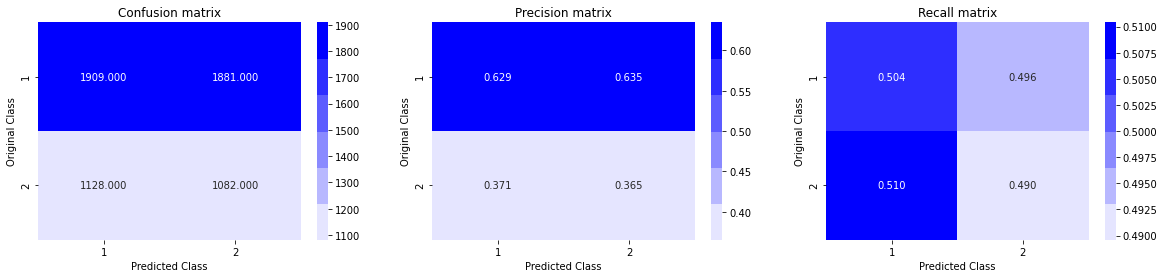

In [13]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.658062695239062
For values of alpha =  0.0001 The log loss is: 0.5340768369723733
For values of alpha =  0.001 The log loss is: 0.4842434395189358
For values of alpha =  0.01 The log loss is: 0.48264056328556515
For values of alpha =  0.1 The log loss is: 0.4755339965969359
For values of alpha =  1 The log loss is: 0.49539527617287
For values of alpha =  10 The log loss is: 0.5235056372813369


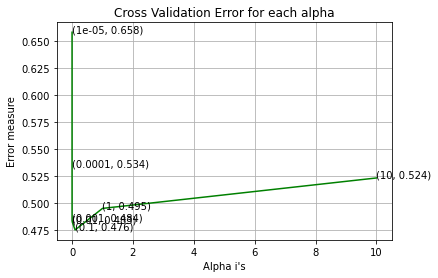

For values of best alpha =  0.1 The train log loss is: 0.4339105521796712
For values of best alpha =  0.1 The test log loss is: 0.4755339965969359
Total number of data points : 6000


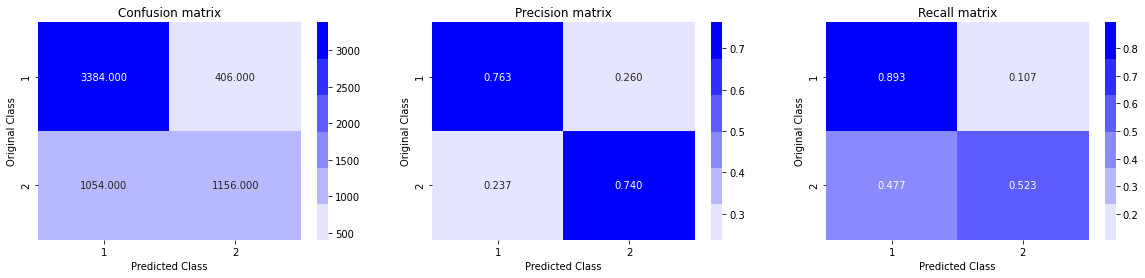

In [14]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.658062695239062
For values of alpha =  0.0001 The log loss is: 0.658062695239062
For values of alpha =  0.001 The log loss is: 0.658062695239062
For values of alpha =  0.01 The log loss is: 0.6211749296265459
For values of alpha =  0.1 The log loss is: 0.6008648649617063
For values of alpha =  1 The log loss is: 0.6369542377808138
For values of alpha =  10 The log loss is: 0.6530788271202652


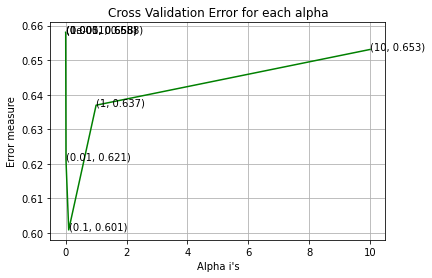

For values of best alpha =  0.1 The train log loss is: 0.5952448236826533
For values of best alpha =  0.1 The test log loss is: 0.6008648649617063
Total number of data points : 6000


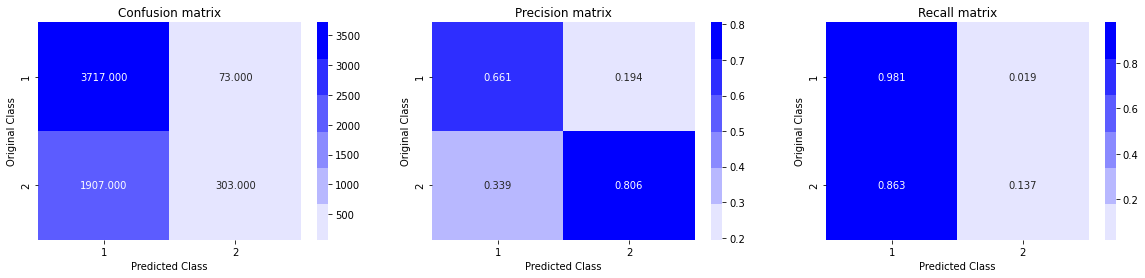

In [15]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 XGBoost </h2>

In [16]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.684688	valid-logloss:0.684851
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.614477	valid-logloss:0.616287
[20]	train-logloss:0.563165	valid-logloss:0.566383
[30]	train-logloss:0.523959	valid-logloss:0.528204
[40]	train-logloss:0.493931	valid-logloss:0.499174
[50]	train-logloss:0.470374	valid-logloss:0.47657
[60]	train-logloss:0.451299	valid-logloss:0.458504
[70]	train-logloss:0.435911	valid-logloss:0.444087
[80]	train-logloss:0.423117	valid-logloss:0.431993
[90]	train-logloss:0.41254	valid-logloss:0.422122
[100]	train-logloss:0.403587	valid-logloss:0.413839
[110]	train-logloss:0.396028	valid-logloss:0.406926
[120]	train-logloss:0.389669	valid-logloss:0.40145
[130]	train-logloss:0.38419	valid-logloss:0.396761
[140]	train-logloss:0.379274	valid-logloss:0.393019
[150]	train-logloss:0.374947	valid-logloss:0.389661
[160]	train-logloss:0.371267	val

Total number of data points : 6000


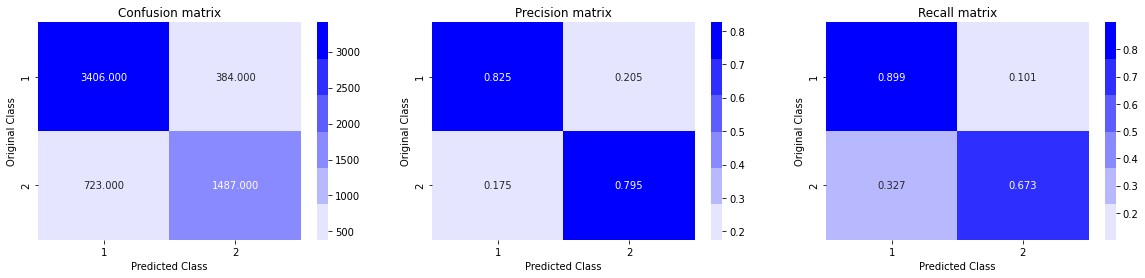

In [17]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h5>After trying the above models I managed to arrive at a log loss value of 0.3622905343963939.I will try to improve these meterics further in future implementing other model maybe a neural network, and try different hyperparameter tuning on it.</h5>